In [1]:
import os
import datetime
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, save_summary_and_results

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


folder_path = '/home/rl_sim/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_F_GRIP/'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_Fnew_GRIP_NotNorm+'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

IN_SHAPE = (800,)

2024-09-08 00:08:04.872041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 00:08:04.897911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 00:08:05.298607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (1465, 800)
y_data shape: (1465,)
X_data.[0] shape:  (800,)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800)    ||  Dimensions of y_val:   (293,)


2024-09-08 00:08:05.603730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 00:08:05.603887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 00:08:05.628133: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# EAIEST FF-ANN

2024-09-06 20:09:24.972980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-06 20:09:24.973183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-06 20:09:24.973299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,153 (1.04 MB)

 Trainable params: 272,129 (1.04 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/25


I0000 00:00:1725646165.603792  221134 service.cc:145] XLA service 0x7f9d8c01e8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725646165.603829  221134 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-06 20:09:25.635324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 20:09:25.724825: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5312 - loss: 0.7875

I0000 00:00:1725646166.373918  221134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5683 - loss: 0.9142 - val_accuracy: 0.5700 - val_loss: 2.7470
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6587 - loss: 0.6181 - val_accuracy: 0.6280 - val_loss: 1.3393
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6904 - loss: 0.5949 - val_accuracy: 0.6416 - val_loss: 1.0345
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6949 - loss: 0.5414 - val_accuracy: 0.6109 - val_loss: 1.2509
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6802 - loss: 0.5470 - val_accuracy: 0.6416 - val_loss: 0.8049
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7191 - loss: 0.5431 - val_accuracy: 0.6246 - val_loss: 0.8028
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7170 - loss: 0.5463 - val_accuracy: 0.6621 - val_loss: 0.6342
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.7086 - loss: 0.5694 - val_accuracy: 0.6519 - val_loss: 0

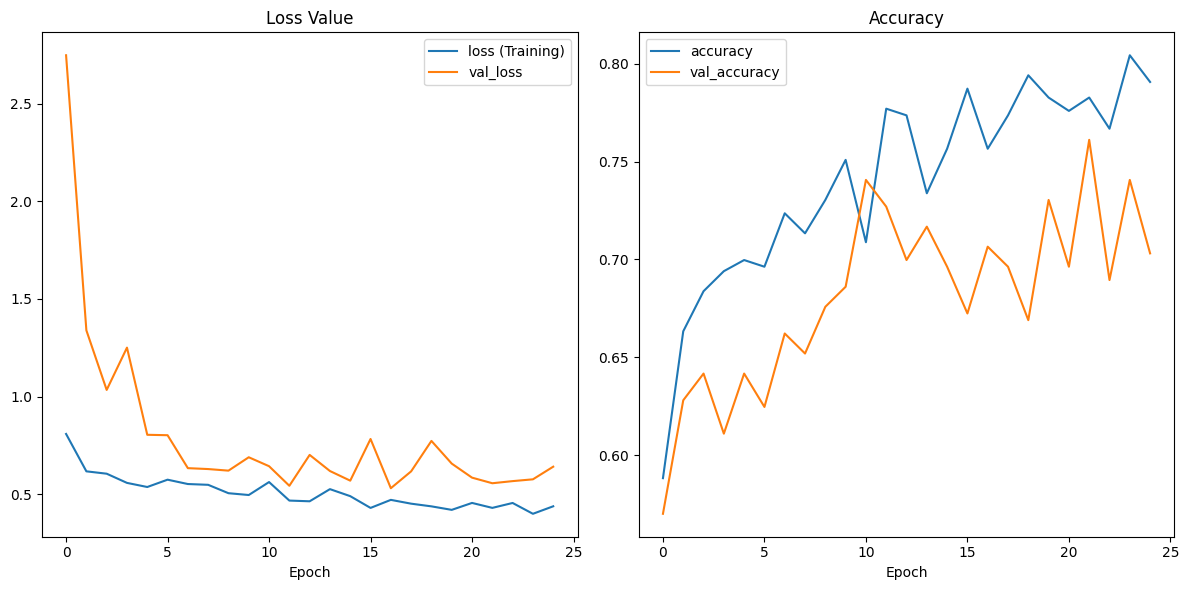

Train loss: 0.4390222132205963
Test val_loss: 0.6416776180267334
Train accuracy: 0.7906712293624878
Accuracy Score: 0.7918088737201365
F1 Score: 0.8134556574923547
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.70      0.76       141
         1.0       0.76      0.88      0.81       152

    accuracy                           0.79       293
   macro avg       0.80      0.79      0.79       293
weighted avg       0.80      0.79      0.79       293



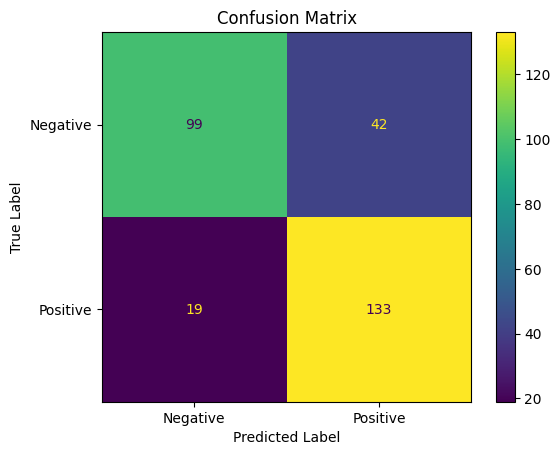

In [2]:
def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
# plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [9]:
# model_name = "FF_ANN_2LAyerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/10


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - auc: 0.8805 - loss: 0.4432 - val_auc: 0.8547 - val_loss: 0.5179
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8902 - loss: 0.4234 - val_auc: 0.7896 - val_loss: 0.6438
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8903 - loss: 0.4216 - val_auc: 0.9027 - val_loss: 0.4316
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9144 - loss: 0.3772 - val_auc: 0.8258 - val_loss: 0.5548
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9207 - loss: 0.3601 - val_auc: 0.8770 - val_loss: 0.4817
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8906 - loss: 0.4295 - val_auc: 0.8881 - val_loss: 0.5925
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9081 - loss: 0.3986 - val_auc: 0.8990 - val_loss: 0.4504
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9168 - loss: 0.3709 - val_auc: 0.8926 - val_loss: 0.4029
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9083 - loss: 0.3827 - v

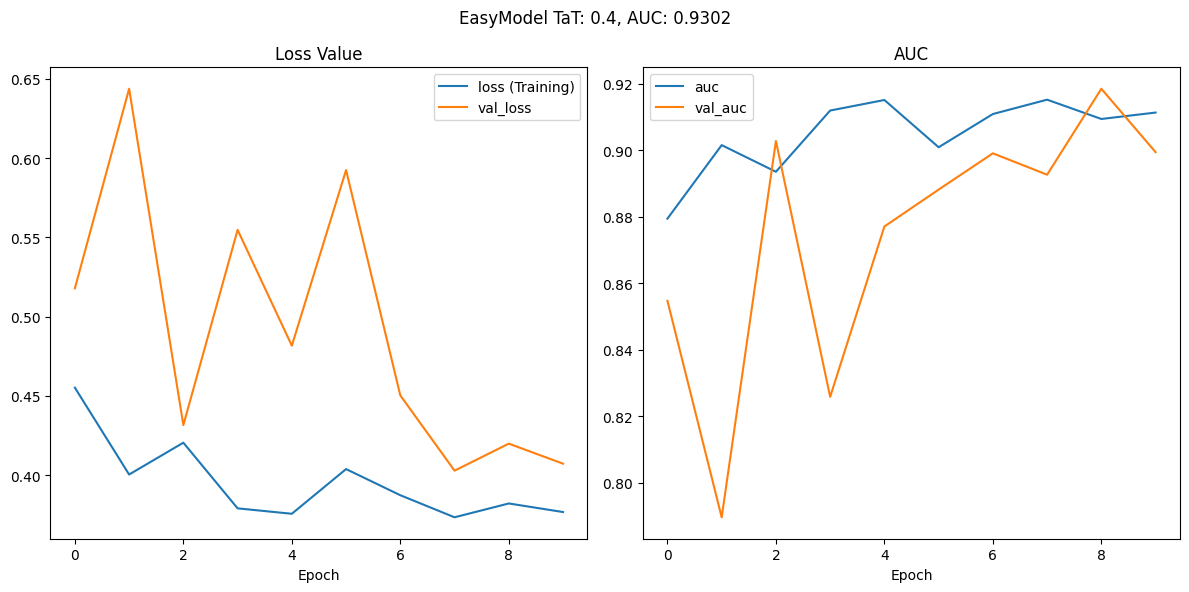

Train loss: 0.37680816650390625
Test val_loss: 0.4073093831539154
AUC: 0.9301978350130645
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.78      0.81       141
         1.0       0.81      0.88      0.84       152

    accuracy                           0.83       293
   macro avg       0.83      0.83      0.83       293
weighted avg       0.83      0.83      0.83       293



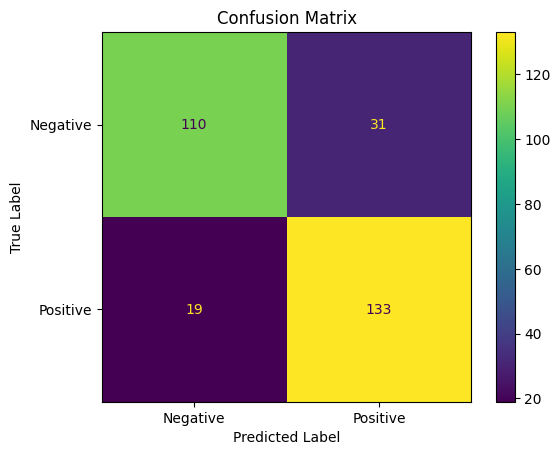

In [4]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 'NORMAL' FF-ANN (few layers)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 526)            │       421,326 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 526)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       134,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,775 (2.19 MB)

 Trainable params: 573,263 (2.19 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5965 - loss: 0.7004 - val_accuracy: 0.5427 - val_loss: 0.8012
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6774 - loss: 0.6335 - val_accuracy: 0.6689 - val_loss: 0.6198
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6493 - loss: 0.6169 - val_accuracy: 0.6485 - val_loss: 1.0159
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6955 - loss: 0.5709 - val_accuracy: 0.7065 - val_loss: 0.5275
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.5846 - val_accuracy: 0.7065 - val_loss: 0.4989
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7402 - loss: 0.5295 - val_accuracy: 0.7952 - val_loss: 0.4907
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7390 - loss: 0.5003 - val_accuracy: 0.7372 - val_loss: 0.4958
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7655 - loss: 0.4881 - val_accuracy: 0.6860 - val_lo

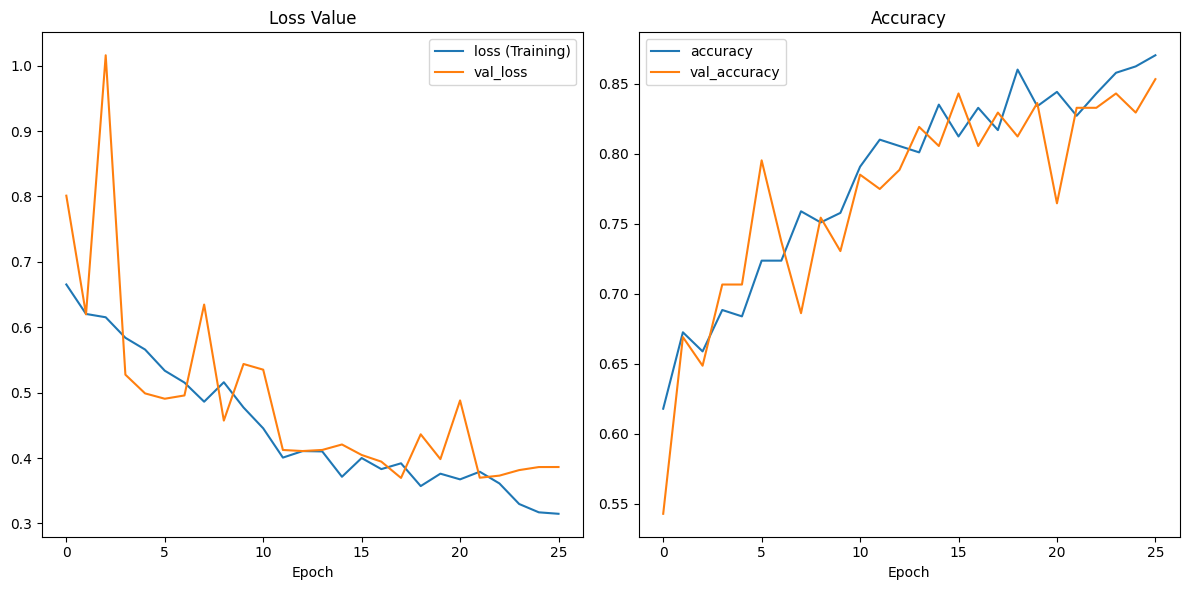

Train loss: 0.3148222267627716
Test val_loss: 0.3863445818424225
Train accuracy: 0.8703071475028992
Accuracy Score: 0.8225255972696246
F1 Score: 0.8354430379746836
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.77      0.81       141
         1.0       0.80      0.87      0.84       152

    accuracy                           0.82       293
   macro avg       0.82      0.82      0.82       293
weighted avg       0.82      0.82      0.82       293



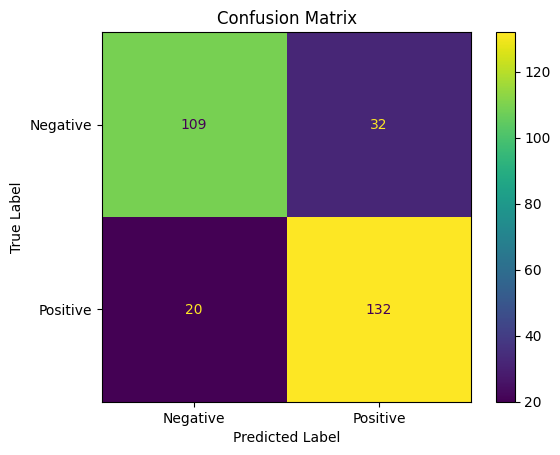

In [8]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def build_ff_ann():
    # Define the input layer
    inputs = Input(shape=(800,))

    # First Dense layer with ReLU activation
    x = Dense(526, activation='relu')(inputs)
    x = Dropout(0.2)(x)  # Add dropout for regularization

    # Second Dense layer with ReLU activation
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # Add batch normalization

    # Third Dense layer with ReLU activation
    x = Dense(64, activation='relu')(x)

    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
# plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [3]:
# import os
# from tensorflow.keras.models import save_model

# model_name = "FF_ANN_4LayerModel_v1"
# # from ML_models_functions import save_summary_and_results
# # save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/25


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.6548 - loss: 0.8674 - val_auc: 0.5267 - val_loss: 2.6590
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7898 - loss: 0.5773 - val_auc: 0.5908 - val_loss: 2.1718
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7862 - loss: 0.5582 - val_auc: 0.7129 - val_loss: 0.7495
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7988 - loss: 0.5525 - val_auc: 0.7838 - val_loss: 0.7806
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8288 - loss: 0.5004 - val_auc: 0.8393 - val_loss: 0.5340
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8828 - loss: 0.4359 - val_auc: 0.8614 - val_loss: 0.5494
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8402 - loss: 0.4860 - val_auc: 0.8720 - val_loss: 0.4888
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8563 - loss: 0.4789 - val_auc: 0.8706 - val_loss: 0.5277
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8505 - loss: 0.4810 - v

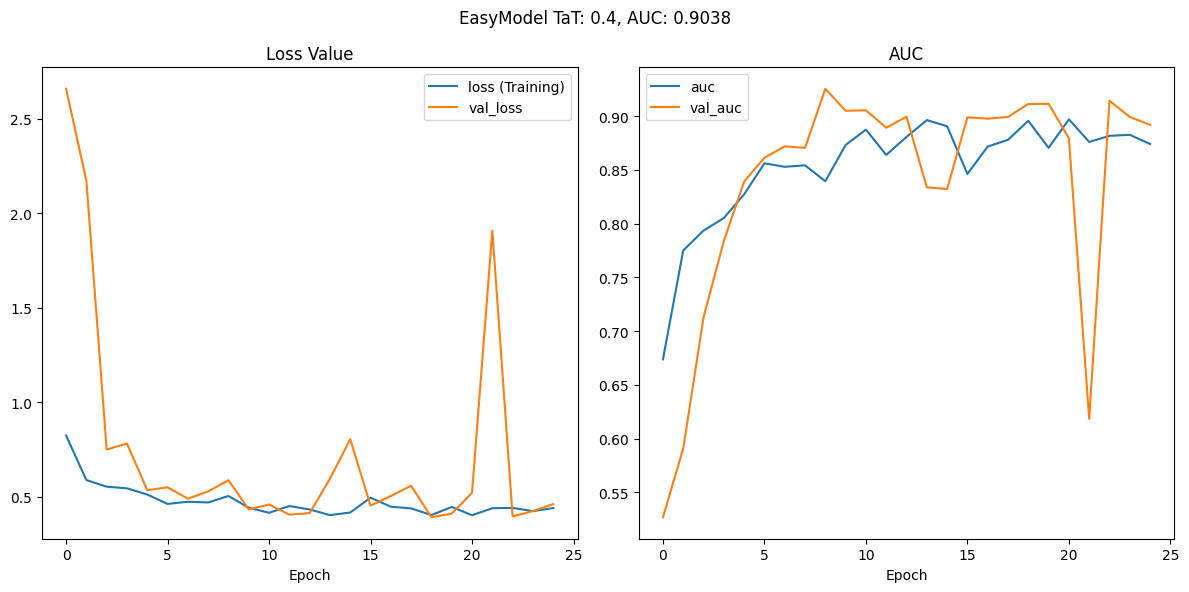

Train loss: 0.43949195742607117
Test val_loss: 0.4602030813694
AUC: 0.9038375296303414
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       129
         1.0       0.83      0.79      0.81       121

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



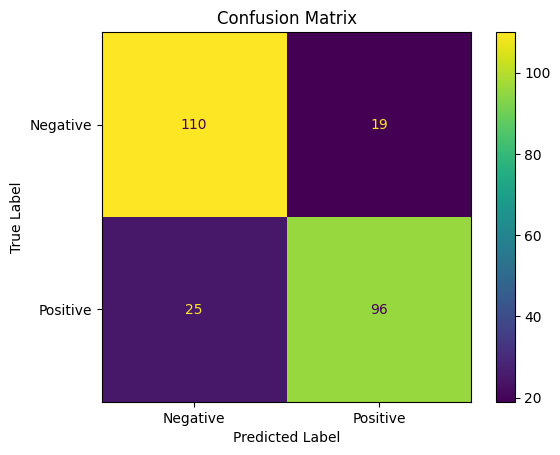

In [13]:
def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [14]:
# model_name = "FF_ANN_3LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, auc, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# COMPLEX-BULKY FF-ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,465 (1.18 MB)

 Trainable params: 309,185 (1.18 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5415 - loss: 0.7713 - val_accuracy: 0.4040 - val_loss: 8.4309
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7088 - loss: 0.5683 - val_accuracy: 0.5400 - val_loss: 2.8482
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7192 - loss: 0.5084 - val_accuracy: 0.5800 - val_loss: 1.8760
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7648 - loss: 0.4554 - val_accuracy: 0.5600 - val_loss: 0.9468
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7475 - loss: 0.4956 - val_accuracy: 0.5560 - val_loss: 0.8343
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.4868 - val_accuracy: 0.6080 - val_loss: 1.4645
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7587 - loss: 0.4798 - val_accuracy: 0.6240 - val_loss: 0.7004
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7919 - loss: 0.4202 - val_accuracy: 0.7440 - val_loss

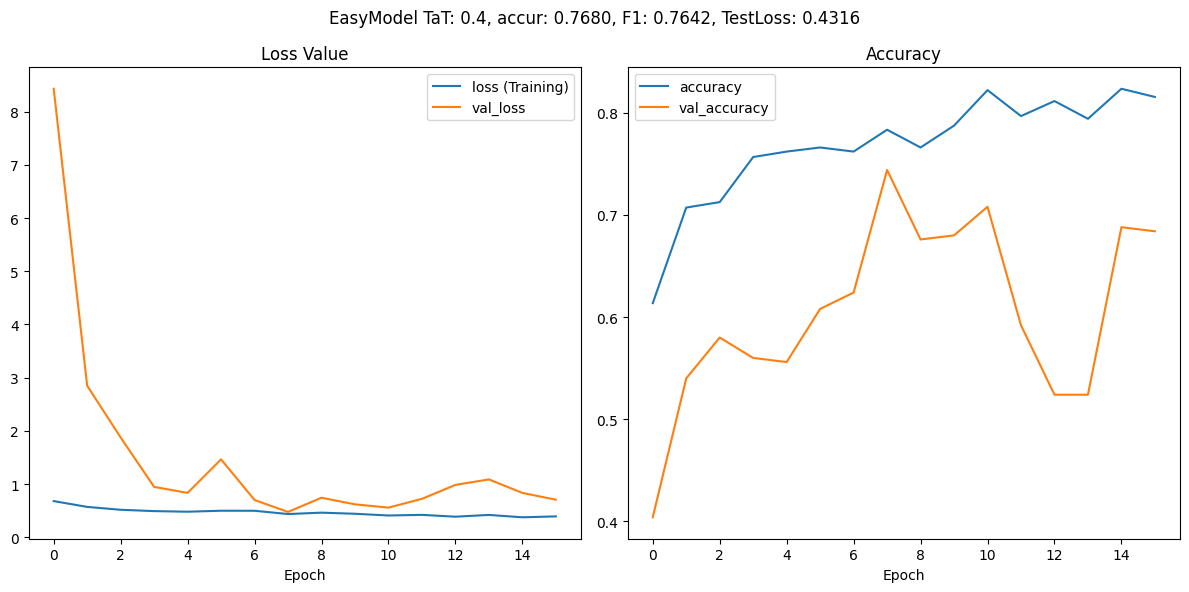

Train loss: 0.3920981287956238
Test val_loss: 0.7063074111938477
Train accuracy: 0.8155080080032349
Accuracy Score: 0.768
F1 Score: 0.7642276422764228
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       129
         1.0       0.75      0.78      0.76       121

    accuracy                           0.77       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250



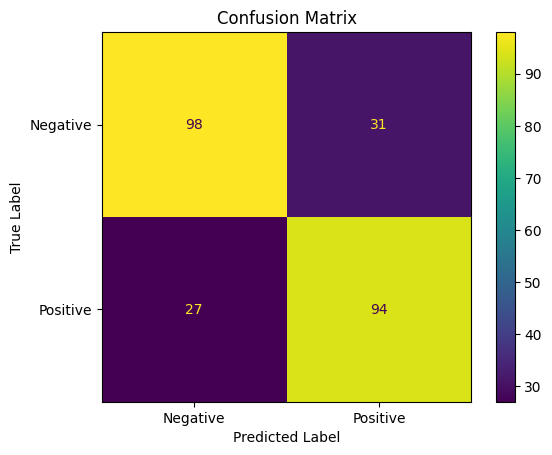

In [15]:

def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Dense(256)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [16]:
# model_name = "FF_ANN_5LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/25


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - auc: 0.8611 - loss: 0.4571 - val_auc: 0.7870 - val_loss: 0.6027
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8917 - loss: 0.4148 - val_auc: 0.8516 - val_loss: 0.5651
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8667 - loss: 0.4541 - val_auc: 0.8469 - val_loss: 0.6641
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9045 - loss: 0.3905 - val_auc: 0.8519 - val_loss: 0.7564
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9112 - loss: 0.3736 - val_auc: 0.8744 - val_loss: 0.5243
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9044 - loss: 0.3968 - val_auc: 0.8579 - val_loss: 0.6268
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8781 - loss: 0.4397 - val_auc: 0.6814 - val_loss: 2.0262
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8672 - loss: 0.4661 - val_auc: 0.8384 - val_loss: 0.8812
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9037 - loss: 0.3906 - v

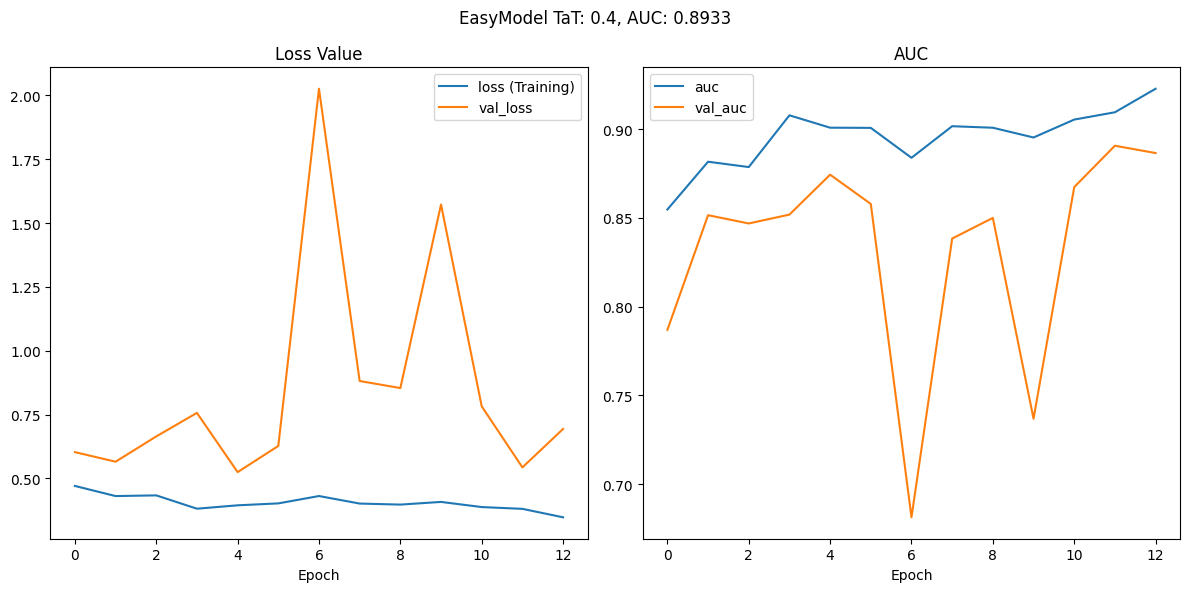

Train loss: 0.347295343875885
Test val_loss: 0.6934163570404053
AUC: 0.8933307707092062
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.96      0.83       129
         1.0       0.94      0.62      0.75       121

    accuracy                           0.80       250
   macro avg       0.83      0.79      0.79       250
weighted avg       0.83      0.80      0.79       250



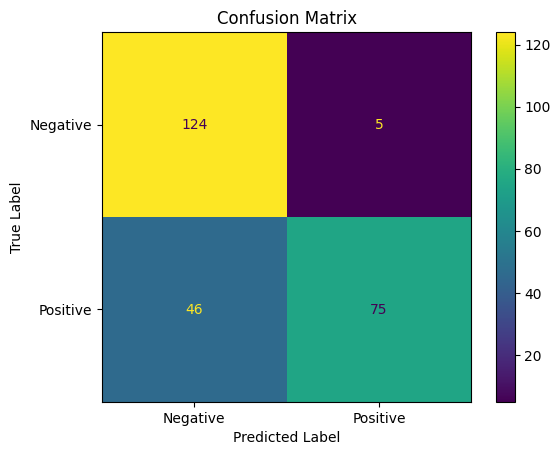

In [17]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [18]:
# model_name = "FF_ANN_Model_v1_AUCmetrics"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# BRANCHED ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    205,056 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 256)       │    205,056 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │    102,528 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │    102,528 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_27[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │     51,264 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ leaky_re_lu_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │      2,080 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │     16,448 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 352)       │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_24[0][0],   │
│                     │                   │            │ dense_26[0][0],   │
│                     │                   │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 352)       │      1,408 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 759,457 (2.90 MB)

 Trainable params: 758,241 (2.89 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.6255 - loss: 0.7335 - val_accuracy: 0.4720 - val_loss: 1.3637
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7368 - loss: 0.5070 - val_accuracy: 0.7440 - val_loss: 0.6847
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7171 - loss: 0.5416 - val_accuracy: 0.7320 - val_loss: 0.6949
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7563 - loss: 0.5343 - val_accuracy: 0.7200 - val_loss: 0.6671
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7721 - loss: 0.4513 - val_accuracy: 0.5320 - val_loss: 1.2377
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7341 - loss: 0.5440 - val_accuracy: 0.5360 - val_loss: 1.2654
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.4161 - val_accuracy: 0.7800 - val_loss: 0.5742
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8089 - loss: 0.4143 - val_accuracy: 0.7520 - val_los

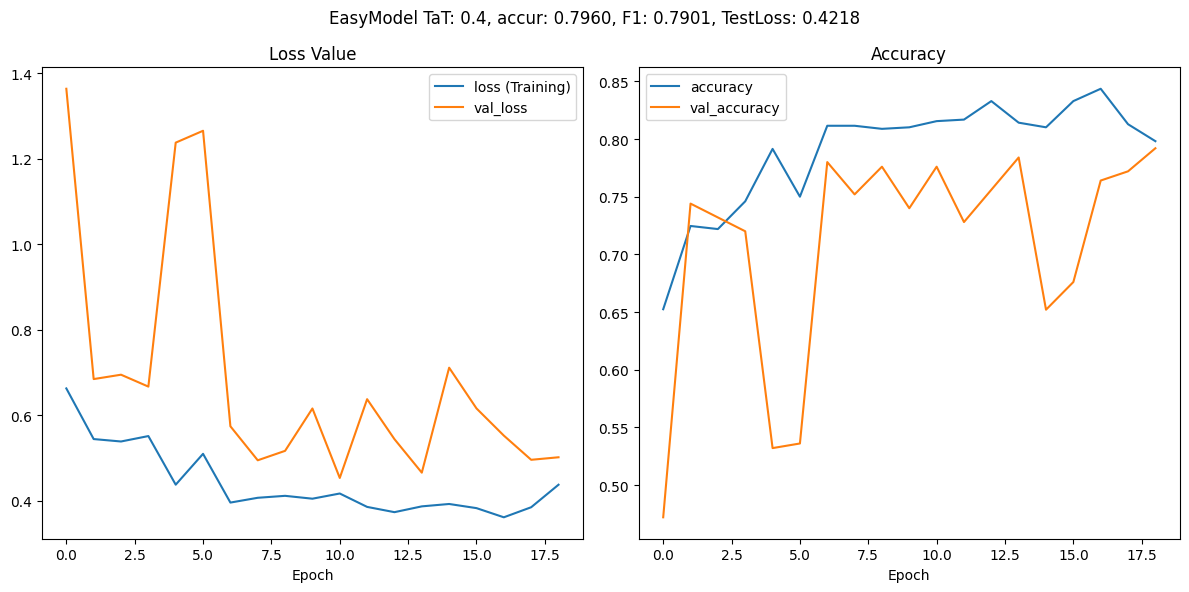

Train loss: 0.43756023049354553
Test val_loss: 0.501772403717041
Train accuracy: 0.7981283664703369
Accuracy Score: 0.796
F1 Score: 0.7901234567901234
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       129
         1.0       0.79      0.79      0.79       121

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



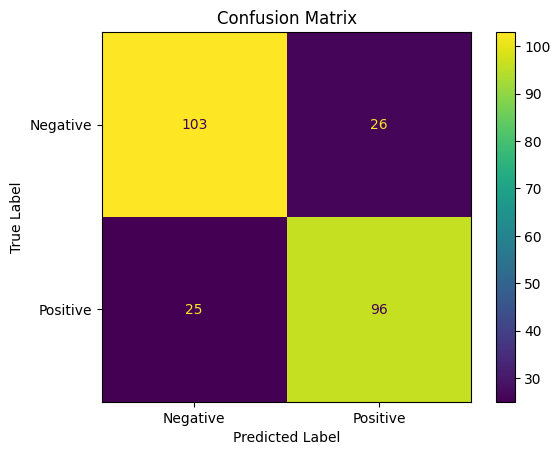

In [19]:
def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(input_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(input_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(input_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(input_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Branch 5
    branch5 = Dense(256, kernel_initializer=GlorotUniform())(input_layer)
    branch5 = LeakyReLU(alpha=0.1)(branch5)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(64, kernel_initializer=GlorotUniform(), activation='relu')(branch5)


    # Merge branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output, branch5_output])
    merged = BatchNormalization()(merged)
    merged = Dense(64, activation='relu')(merged)
    
    output_layer = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [20]:
# model_name = "FF_ANN_BRANCHEDModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/25


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - auc: 0.8613 - loss: 0.4617 - val_auc: 0.7470 - val_loss: 1.0308
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9070 - loss: 0.3844 - val_auc: 0.6967 - val_loss: 1.3881
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9158 - loss: 0.3697 - val_auc: 0.6657 - val_loss: 1.8841
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8904 - loss: 0.4230 - val_auc: 0.7444 - val_loss: 2.0604
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9122 - loss: 0.3716 - val_auc: 0.8016 - val_loss: 1.0632
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9294 - loss: 0.3309 - val_auc: 0.8356 - val_loss: 0.8388
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9051 - loss: 0.4107 - val_auc: 0.7124 - val_loss: 1.6618
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8807 - loss: 0.4373 - val_auc: 0.9062 - val_loss: 0.5534
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9215 - loss: 0.3517 - 

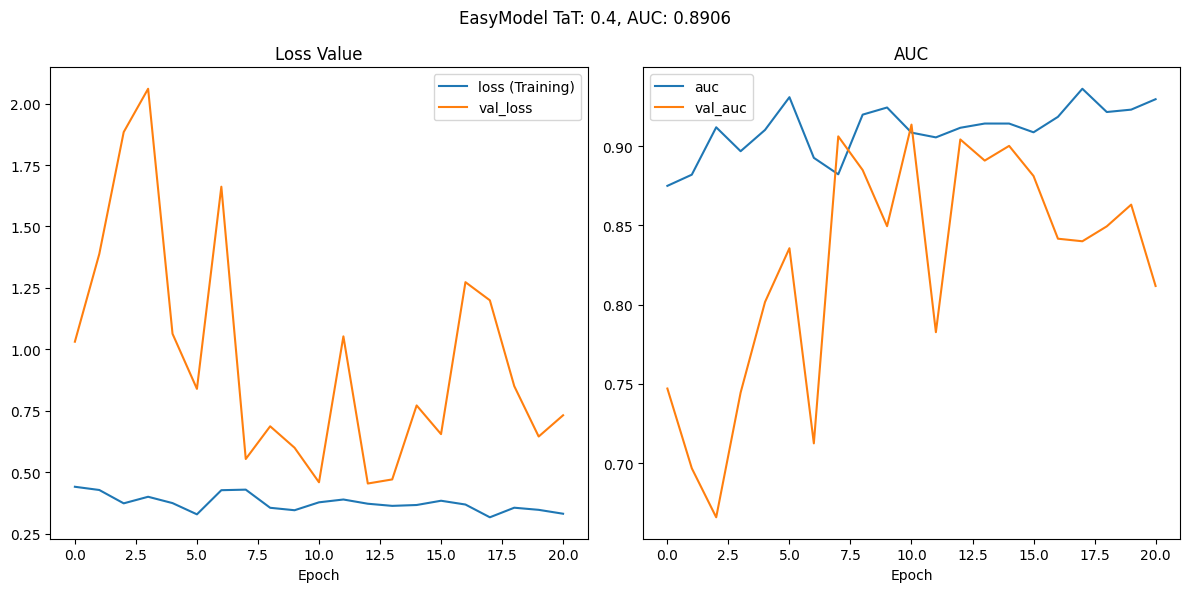

Train loss: 0.3305845558643341
Test val_loss: 0.7313643097877502
AUC: 0.8906400153757448
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.81       129
         1.0       0.82      0.72      0.77       121

    accuracy                           0.79       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250



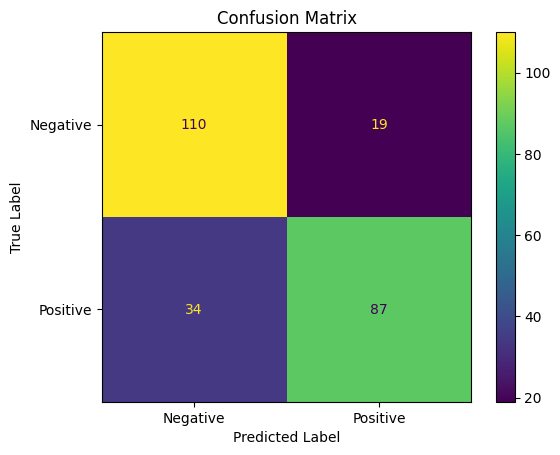

In [21]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# ARTICULATED BRANCH

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 256)       │    205,056 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_51[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 128)       │    102,528 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 128)       │    102,528 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │     51,264 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 128)       │     32,896 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 64)        │      8,256 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 32)        │      2,080 │ dense_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 288)       │          0 │ dense_52[0][0],   │
│ (Concatenate)       │                   │            │ dense_54[0][0],   │
│                     │                   │            │ dense_56[0][0],   │
│                     │                   │            │ dense_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288)       │      1,152 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 128)       │     36,992 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │      8,256 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 64)        │      8,256 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 64)        │      8,256 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ dense_64[0][0]    │
│ (LeakyReLU)         │                   │            │                 

 Total params: 589,697 (2.25 MB)

 Trainable params: 588,417 (2.24 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.6294 - loss: 0.6749 - val_accuracy: 0.4915 - val_loss: 9.2452
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6538 - loss: 0.6580 - val_accuracy: 0.5495 - val_loss: 1.7282
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7397 - loss: 0.5214 - val_accuracy: 0.5017 - val_loss: 1.1148
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7113 - loss: 0.5487 - val_accuracy: 0.6143 - val_loss: 0.8261
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.4586 - val_accuracy: 0.6758 - val_loss: 0.7093
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7806 - loss: 0.4792 - val_accuracy: 0.6826 - val_loss: 0.6580
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - loss: 0.4587 - val_accuracy: 0.6075 - val_loss: 0.7691
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.4430 - val_accuracy: 0.6997 - val_lo

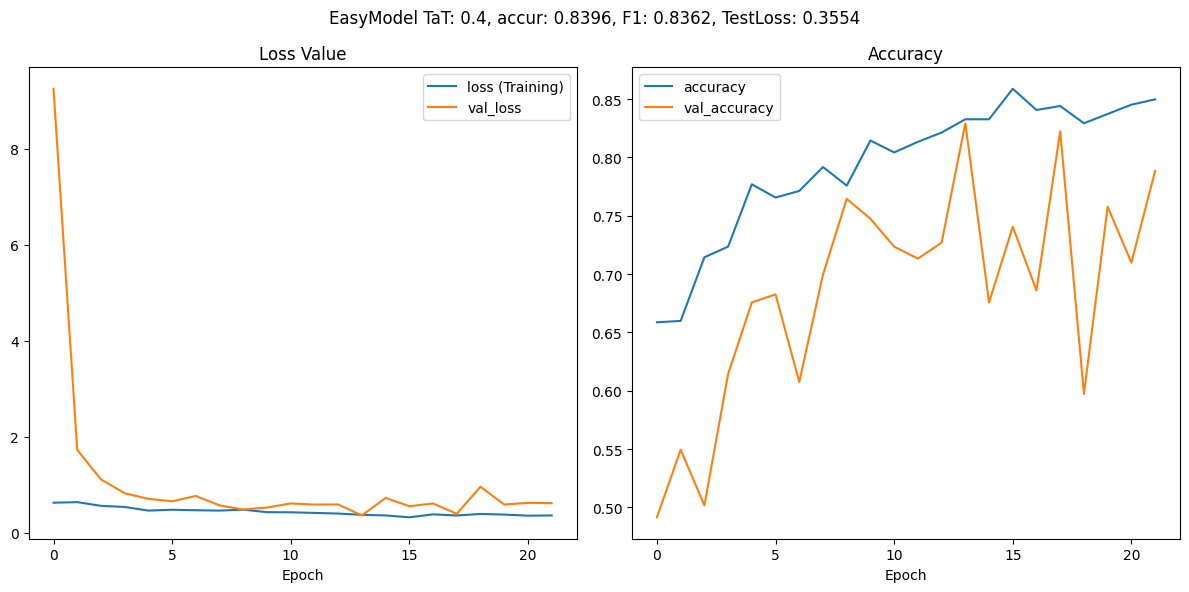

Train loss: 0.3638678789138794
Test val_loss: 0.6194580793380737
Train accuracy: 0.849829375743866
Accuracy Score: 0.8395904436860068
F1 Score: 0.8362369337979094
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       141
         1.0       0.89      0.79      0.84       152

    accuracy                           0.84       293
   macro avg       0.84      0.84      0.84       293
weighted avg       0.84      0.84      0.84       293



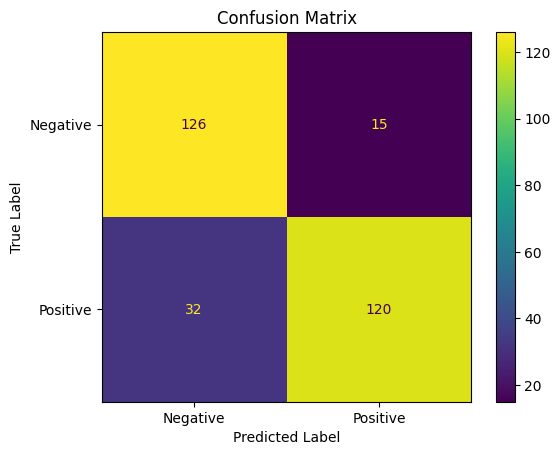

In [5]:
from tensorflow.keras.initializers import GlorotUniform

def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(input_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(input_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(input_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(input_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Merge the first four branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation='relu')(merged)
    
    # Split into three new branches
    branch5 = Dense(64, activation='relu')(merged)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(32, activation='relu')(branch5)
    
    branch6 = Dense(64, activation='relu')(merged)
    branch6 = Dropout(0.2)(branch6)
    branch6_output = Dense(32, activation='relu')(branch6)
    
    branch7 = Dense(64, kernel_initializer=GlorotUniform())(merged)
    branch7 = LeakyReLU(alpha=0.1)(branch7)
    branch7 = Dropout(0.2)(branch7)
    branch7_output = Dense(32, kernel_initializer=GlorotUniform(), activation='relu')(branch7)
    
    # Merge the three branches
    final_merge = concatenate([branch5_output, branch6_output, branch7_output])
    final_merge = BatchNormalization()(final_merge)
    final_merge = Dense(64, activation='relu')(final_merge)
    
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(final_merge)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# To create the model
model = build_ff_ann()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [3]:
# model_name = "FF_ANN_ArticulatedModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)